In [1]:
# remove futurewarnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
!nvidia-smi

Tue Jul  1 13:45:47 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.02              Driver Version: 555.42.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   48C    P8             30W /  350W |      50MiB /  24576MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import jax
import jax.numpy as jnp
from jax import jit
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from qdax_es.utils.count_plots import plot_archive_value
from qdax_es.core.containers.count_repertoire import CountMapElitesRepertoire
jax.devices()

Matplotlib created a temporary cache directory at /tmp/matplotlib-ks0x7wir because the default path (/home_nfs/paul/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


[CudaDevice(id=0)]

In [4]:
from qdax_es.utils.gaussian_process import GPState, train_gp, gp_predict, gp_batch_predict

In [5]:
# from jax.config import config
# jax.config.update("jax_enable_x64", True)

# config.update("jax_debug_nans", True)

In [6]:
num_centroids = 1000

# Bounds
minval, maxval = -1, 1

# Generate random centroids
key = jax.random.PRNGKey(0)
centroids = jax.random.uniform(key, (num_centroids, 2), minval=minval, maxval=maxval)

In [7]:
@jit
def f(x):
    return jnp.sin(x[0] + x[1]) * 50 - 200

count = jax.random.choice(key, jnp.arange(2), shape=(num_centroids,))
# count = jnp.ones(num_centroids)
# Put fitness if count > 0
mask = count > 0
fitnesses = jnp.where(mask, f(centroids.T), -jnp.inf)
descriptors = centroids
mask.sum()

Array(504, dtype=int32)

In [8]:
%matplotlib inline

In [9]:
repertoire = CountMapElitesRepertoire(
    genotypes=None, 
    fitnesses=fitnesses,
    descriptors=descriptors,
    centroids=centroids,
    count=count,
)
plot_archive_value(
    repertoire=repertoire,
    y= fitnesses,
    title="Initial Archive",
    minval=minval,
    maxval=maxval,
)

%matplotlib inline

plt.show()

TypeError: CountMapElitesRepertoire.__init__() missing 2 required positional arguments: 'extra_scores' and 'keys_extra_scores'

In [ ]:
gp_state = GPState.init(
    x=centroids,
    y=fitnesses,
    weighted=True,
    count=count,
    empty_weight=1e3,
)

Valid params: 31
NaNs 0
1 RBFParams(sigma=Array(0.58385676, dtype=float32), lengthscale=Array(0.34158432, dtype=float32), obs_noise_sigma=Array(0.5120434, dtype=float32))
Negative variance 0
Mean: -250.99249267578125 | -149.36932373046875
Var: 0.010960012674331665 | 0.09426131844520569


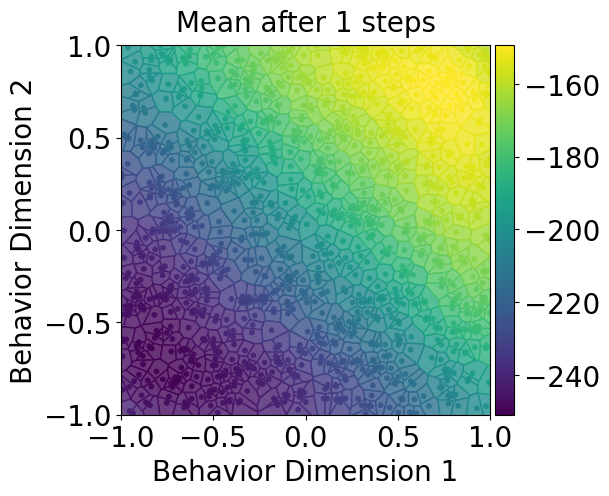

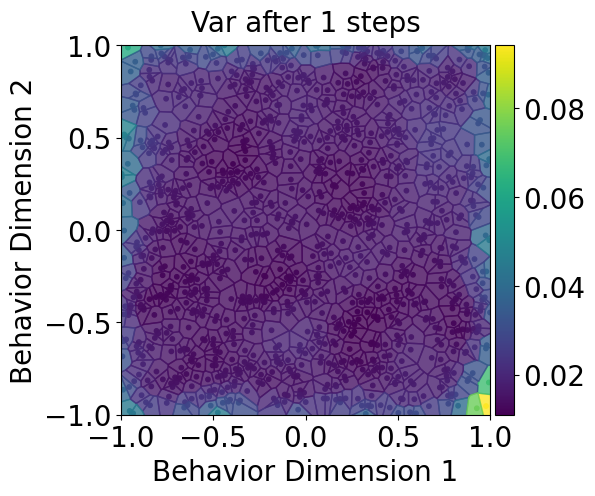

Valid params: 31
NaNs 0
10 RBFParams(sigma=Array(0.67060935, dtype=float32), lengthscale=Array(0.42645675, dtype=float32), obs_noise_sigma=Array(0.59871376, dtype=float32))
Negative variance 0
Mean: -250.3566131591797 | -149.49087524414062
Var: 0.010528713464736938 | 0.09293720126152039


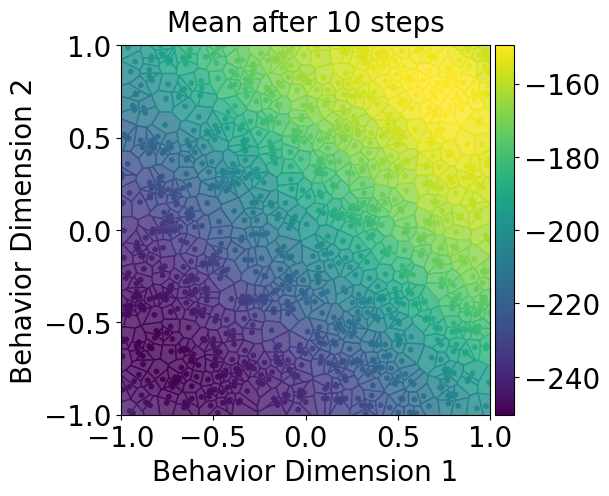

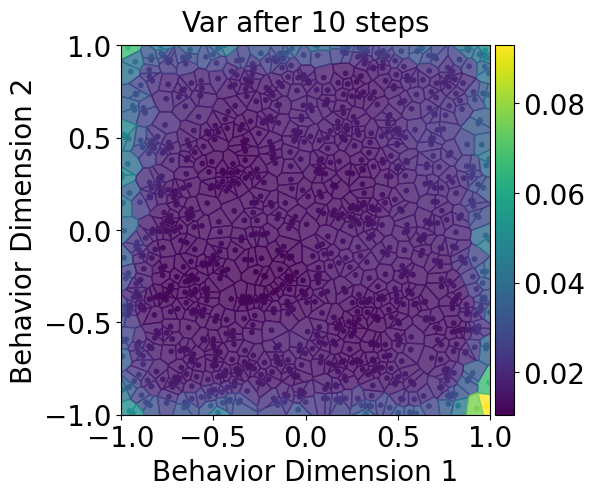

Valid params: 31
NaNs 0
100 RBFParams(sigma=Array(1.1078609, dtype=float32), lengthscale=Array(0.6886807, dtype=float32), obs_noise_sigma=Array(1.0137656, dtype=float32))
Negative variance 0
Mean: -249.56100463867188 | -150.33749389648438
Var: 0.01641857624053955 | 0.12949788570404053


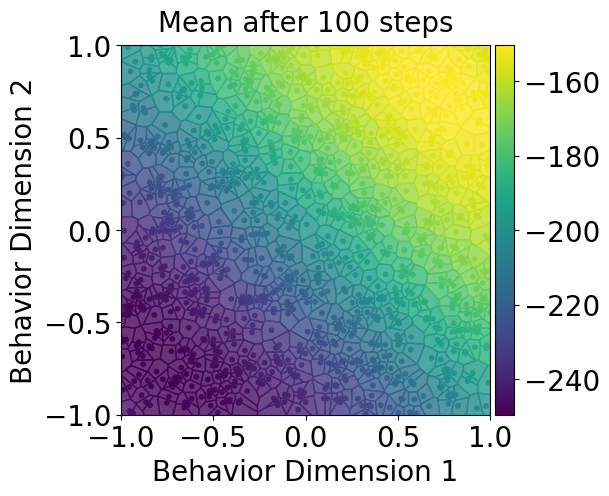

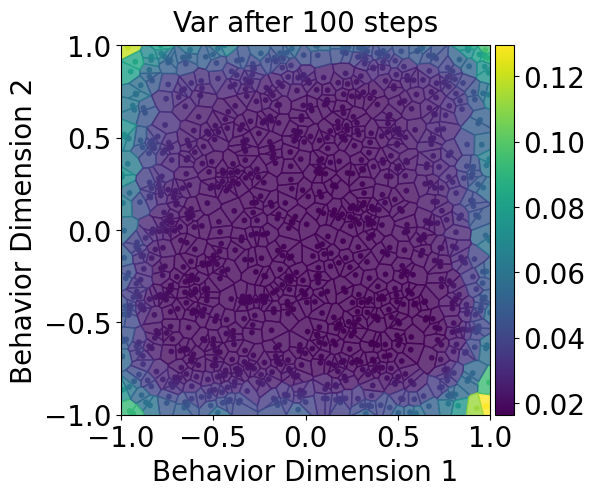

In [ ]:
# Run the training loop with scan
steps = [1, 10, 100]
# steps = [1000]

for num_steps in steps:
    with jax.disable_jit():
        fit_gp_state = train_gp(gp_state, num_steps=num_steps)
    print(num_steps, fit_gp_state.kernel_params)
    mean, var = gp_batch_predict(fit_gp_state, centroids)
    print(f"Mean: {mean.min()} | {mean.max()}")
    print(f"Var: {var.min()} | {var.max()}")
    plot_archive_value(
        repertoire=repertoire,
        y=mean,
        title=f"Mean after {num_steps} steps",
        minval=minval,
        maxval=maxval,
    )
    plot_archive_value(
        repertoire=repertoire,
        y=var,
        title=f"Var after {num_steps} steps",
        minval=minval,
        maxval=maxval,
    )
    plt.show()

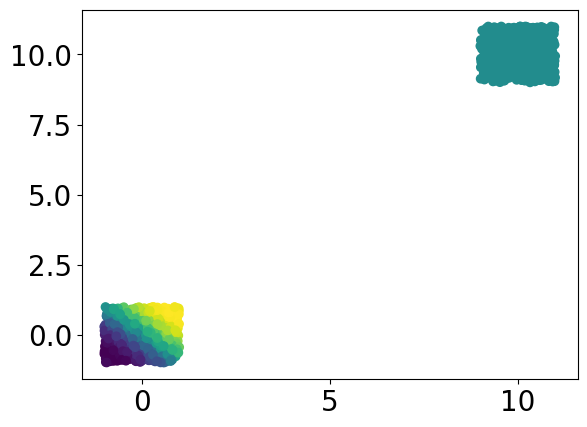

In [ ]:
plt.scatter(fit_gp_state.x[:, 0], fit_gp_state.x[:, 1], c=fit_gp_state.y)

Negative variance 0


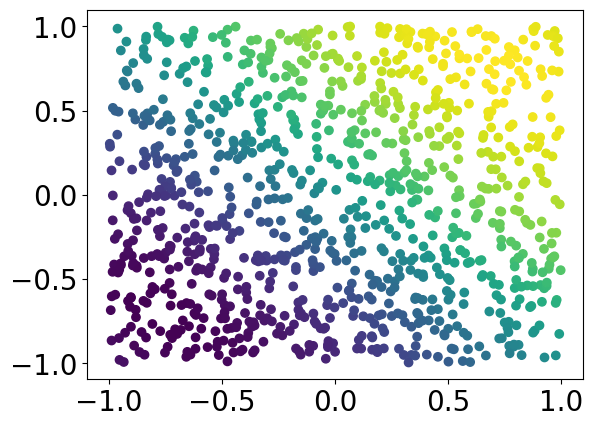

In [ ]:
mean, var = gp_batch_predict(fit_gp_state, centroids)
plt.scatter(centroids[:, 0], centroids[:, 1], c=mean)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'True fitness'}, xlabel='Behavior Dimension 1', ylabel='Behavior Dimension 2'>)

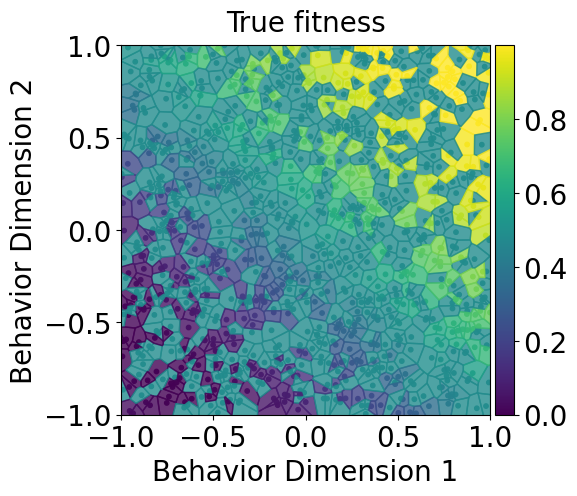

In [ ]:
plot_archive_value(
    repertoire=repertoire,
    y=gp_state.y,
    title="True fitness",
    minval=minval,
    maxval=maxval,
)

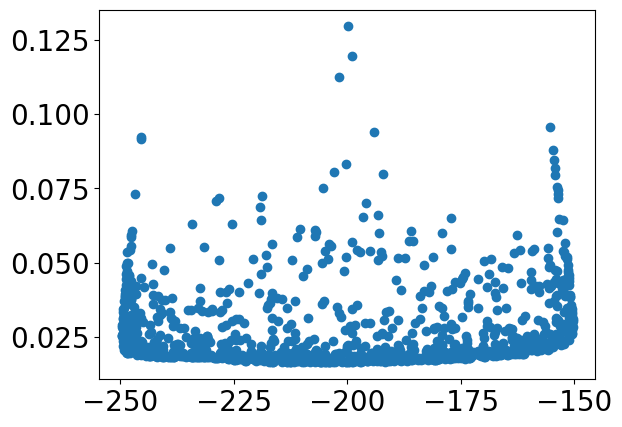

In [ ]:
plt.scatter(mean, var)

In [ ]:
import importlib
# pareto_mod = importlib.import_module("qdax_es.utils.pareto_selection")
# pareto_mod = importlib.reload(pareto_mod)

# pareto_front = pareto_mod.pareto_front

In [ ]:
def pareto_filter(f1, f2):
    def is_dominated(x):
        """Check if a point is dominated."""
        return jnp.any((f1 > x[0]) & (f2 > x[1]))

    # zip f1 and f2
    f = jnp.vstack([f1, f2]).T
    dominated = jax.vmap(is_dominated)(f)
    return ~ dominated

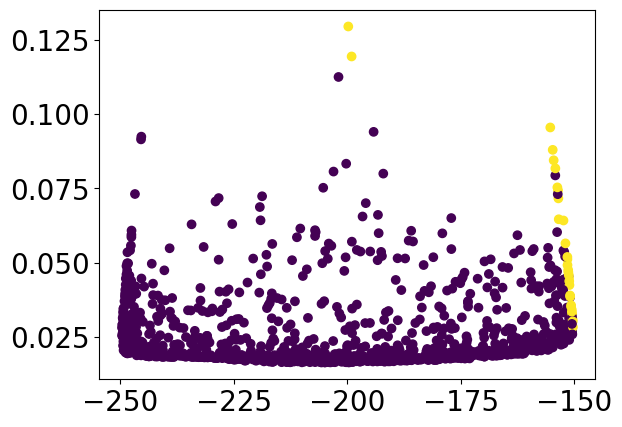

In [ ]:
f = pareto_filter(mean, var)
plt.scatter(mean, var, c=f)

In [ ]:
num_points = 60

indices = jnp.arange(num_centroids)
# proba
p = f / f.sum()
# select
selected = jax.random.choice(
    key, 
    indices, 
    shape=(num_points,), 
    p=p, 
    replace=False
    )
selected

Array([792, 719, 764, 897, 398, 835, 650, 129, 692, 445, 242, 918, 508,
       847, 964, 602, 642, 757, 883, 888, 926, 460,  84, 488, 687, 658,
       465, 184, 140, 903, 247, 436, 484, 374, 420, 360, 493, 877, 303,
       905, 896, 534,  50, 671, 309, 340, 521, 487, 159,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10], dtype=int32)

In [ ]:
for i in selected:
    print(i in indices[f])

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
